In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

In [2]:
# Plotting
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
%matplotlib inline

C:\Users\Erin\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Performance
from time import time

In [4]:
# Helper
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV

In [5]:
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier

# Preliminaries

In [6]:
# Load in the Data
train = pd.read_csv('input/train3.csv')
test = pd.read_csv('input/test3.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,femalesHighClass,thirdClassFSingle,boysHighClass,singleMenFirstClass
0,1,0,3,1,0,1,0,22,7.2500,0,0,0,0
1,2,1,1,1,0,0,1,38,71.2833,1,0,0,0
2,3,1,3,0,0,0,0,26,7.9250,0,0,0,0
3,4,1,1,1,0,0,0,35,53.1000,1,0,0,0
4,5,0,3,0,0,1,0,35,8.0500,0,0,0,0


# Hold-out set

In [8]:
# create hold-out set

features = list(train.columns.values)[2::]
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

# Feature selection

In [9]:
ch2 = SelectKBest(chi2, k = 5)
X_train2 = ch2.fit_transform(X_train, y_train)
X_train2[0:10]

array([[  1.    ,  26.    ,  18.7875,   0.    ,   0.    ],
       [  1.    ,  25.    ,   7.75  ,   0.    ,   0.    ],
       [  1.    ,  24.    ,  24.15  ,   0.    ,   0.    ],
       [  1.    ,  29.    ,  10.5   ,   0.    ,   0.    ],
       [  1.    ,  18.    ,   8.05  ,   0.    ,   0.    ],
       [  0.    ,  35.    ,  20.25  ,   0.    ,   0.    ],
       [  0.    ,  28.    ,  24.    ,   1.    ,   0.    ],
       [  1.    ,  21.    ,  73.5   ,   0.    ,   0.    ],
       [  1.    ,  25.    ,   7.75  ,   0.    ,   0.    ],
       [  0.    ,   2.    ,  27.9   ,   0.    ,   0.    ]])

In [10]:
predictors = list(X_train.columns.values[ch2.get_support()])
print(predictors)

['Gender', 'AgeFill', 'FareFill', 'femalesHighClass', 'thirdClassFSingle']


# Training

In [11]:
# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(X_train[predictors], y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [12]:
# predict class labels
pred = est.predict(X_test[predictors])

In [13]:
# score on test data (accuracy)
acc = est.score(X_test[predictors], y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test[predictors])[0]

ACC: 0.8430


array([ 0.76974955,  0.23025045])

# Model evaluation

In [14]:
def evaluation_metrics(ytest, ypred):
    
    # null accuracy
    null_accuracy = round(ytest.value_counts().max()/len(ytest), 3)
    print("Null accuracy:", null_accuracy)

    accuracy = round(accuracy_score(ytest, ypred), 3)
    print("Accuracy:", accuracy)
    
    confusion = confusion_matrix(ytest, ypred)
    print("Confusion matrix: actual(0,1) x predicted(0,1)\n", confusion)
    
    sensitivity = round(recall_score(ytest, ypred), 3)
    print("Sensitivity: when actual is positive, how often predicted positive", sensitivity)
    
    specificity = round(confusion[0,0]/(confusion[0,0] + confusion[0,1]), 3)
    print("Specificity: when actual is zero, how often predicted zero", specificity)

    precision = round(precision_score(ytest, ypred), 3)
    print("Precision: when predicted is positive, how often actual positive", precision)
    
    return accuracy, confusion, sensitivity, specificity, precision

In [15]:
def evaluate_prob(ytest, pred_prob):
    
    # histogram of probabilities
    plt.subplot(1, 2, 1)
    plt.hist(pred_prob, bins = 8)
    plt.xlim(0, 1)
    plt.title('Histogram of pred probabilities')
    plt.xlabel('Predicted probability of positive')
    plt.ylabel('Frequency')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, pred_prob)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve")
    plt.xlabel("False positive rate (1 - specificity)")
    plt.ylabel("True positive rate (sensitivity)")
    plt.grid(True)
    
    plt.tight_layout() # adds more space between plots
    
    auc = round(roc_auc_score(y_test, predict_prob), 3)
    print("AUC score is:", auc)
    
    return fpr, tpr, thresholds, auc

In [16]:
# Use ROC curve to determine sensitivity & specificity for a given threshold
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1-fpr[thresholds > threshold][-1])

In [17]:
# Retrieve evaluation metrics
acc, conf, sens, spec, prec = evaluation_metrics(y_test, pred)

Null accuracy: 0.623
Accuracy: 0.843
Confusion matrix: actual(0,1) x predicted(0,1)
 [[121  18]
 [ 17  67]]
Sensitivity: when actual is positive, how often predicted positive 0.798
Specificity: when actual is zero, how often predicted zero 0.871
Precision: when predicted is positive, how often actual positive 0.788


AUC score is: 0.891


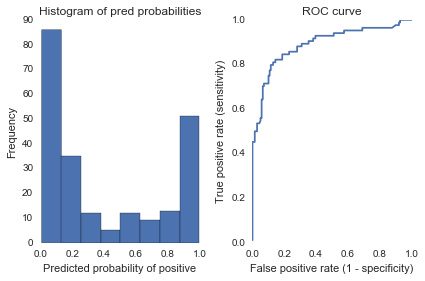

In [18]:
# Predict probabilities for hold-out set
predict_prob = est.predict_proba(X_test[predictors])[:,1]

# Retrieve probability metrics
fpr, tpr, thresholds, auc = evaluate_prob(y_test, predict_prob)

# Final predictions - submission

In [19]:
# Make predictions for test set.
test_pred = est.predict(test[predictors])

In [20]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_pred
    })

# Any files you save will be available in the output tab below
submission.to_csv('submission.csv', index=False)